# <center> Сегментация клиентов онлайн магазина подарков

## Постановка задачи

<center><img src=https://salesupnow.ru/storage/app/media/pipeople.png align="right" width="300"/></center>

Маркетинг — неотъемлемая часть любого бизнеса. Для повышения прибыли компании важно понимать своего клиента, его пожелания и предпочтения. С появлением электронной коммерции, или онлайн-продаж, стало намного проще собирать данные о клиентах, анализировать их, находить закономерности и реализовывать маркетинговые кампании.

Большинство интернет-магазинов используют инструменты веб-аналитики, чтобы отслеживать просмотры страниц, количество и поведение посетителей и коэффициент отказов. Но отчёта из Google Analytics или аналогичной системы может быть недостаточно для полного понимания того, как клиенты взаимодействуют с сайтом. Компаниям важно иметь возможность быстро и точно реагировать на перемены в поведении клиентов, создавая инструменты, которые обнаруживают эти изменения практически в режиме реального времени.

Машинное обучение помогает поисковой системе анализировать огромное количество данных о посетителях платформы, узнавать модели поведения профессиональных покупателей, определять категорию клиентов (например, лояльные/перспективные/новички/спящие/ушедшие) и выбирать правильную стратегию взаимодействия с ними.

Стоит также отметить, что компании, использующие машинное обучение на своих платформах электронной коммерции, могут постоянно повышать эффективность бизнес-процессов: настраивать товарную выборку персонально для каждого покупателя и предлагать выгодную цену в соответствии с бюджетом клиента и т. д. Эта задача относится к категории построения рекомендательных систем, речь о которых пойдёт в следующем разделе нашего курса.

> Как правило, наборы данных для электронной коммерции являются частной собственностью и, следовательно, их трудно найти среди общедоступных данных. Однако [The UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/index.php)  создал набор данных, содержащий фактические транзакции за 2010 и 2011 годы. С ним нам как раз и предлагается поработать в этом кейсе. 

> В нашем распоряжении будет набор данных, который содержит все транзакции, произошедшие в период с 01/12/2010 по 09/12/2011 для базирующейся в Великобритании компании, занимающейся онлайн-розничной торговлей. Компания в основном продает уникальные подарки на все случаи жизни. Многие клиенты компании являются оптовиками.

**Бизнес-задача:** произвести сегментацию существующих клиентов, проинтерпретировать эти сегменты и определить стратегию взаимодействия с ними.

**Техническая задача для вас как для специалиста в Data Science:** построить модель кластеризации клиентов на основе их покупательской способности, частоты заказов и срока давности последней покупки, определить профиль каждого из кластеров.

**Основные цели проекта:**
1. Произвести предобработку исходного набора данных о транзакциях.
2. Провести разведывательный анализ данных и выявить основные закономерности.
3. Сформировать набор данных о характеристиках каждого из уникальных клиентов.
4. Построить несколько моделей машинного обучения, решающих задачу кластеризации клиентов, определить количество кластеров и проинтерпретировать их.
5. Спроектировать процесс предсказания категории интересов клиента и протестировать вашу модель на новых клиентах.

## Данные и их описание

Данные представляют собой таблицу в формате CSV, в каждой строке которой содержится информация об уникальной транзакции.

Признаки, описывающие каждую транзакцию:

* InvoiceNo — номер счёта-фактуры (уникальный номинальный шестизначный номер, присваиваемый каждой транзакции; буква "C" в начале кода указывает на отмену транзакции);
* StockCode — код товара (уникальное пятизначное целое число, присваиваемое каждому отдельному товару);
* Description — название товара;
* Quantity — количество каждого товара за транзакцию;
* InvoiceDate — дата и время выставления счёта/проведения транзакции;
* UnitPrice — цена за единицу товара в фунтах стерлингов;
* CustomerID — идентификатор клиента (уникальный пятизначный номер, однозначно присваиваемый каждому клиенту);
* Country — название страны, в которой проживает клиент.



Импорт базовых библиотек:

In [1]:
import numpy as np
import pandas as pd
rng = np.random.default_rng(seed=123456)
np.set_printoptions(suppress=True, precision=4, linewidth=100)
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_colwidth = 40

from sklearn import preprocessing 
from sklearn import metrics
from sklearn import pipeline
from sklearn import decomposition
from sklearn import cluster
from sklearn import manifold
from sklearn import mixture

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

import utils

## 1. Знакомство со структурой данных

Первым делом необходимо понять, с какими данными предстоит работать, и произвести базовую предобработку данных — перевести признаки в необходимые для дальнейшей работы форматы.

Познакомьтесь с исходными данными поближе:

* Проведите статистический анализ исходных данных, посмотрев на основные диапазоны исходных признаков.
* Узнайте, сколько уникальных клиентов совершали транзакции в указанный период.
* Узнайте, из каких стран совершались транзакции.
* Исследуйте данные на наличие пропусков и дубликатов.
* Переведите столбцы в корректные форматы (например, даты в формат datetime).

In [2]:
df = pd.read_csv('data/data.zip', 
                    encoding='ISO-8859-1', 
                    dtype={'CustomerID': str, 'InvoiceID': str},
                    parse_dates=['InvoiceDate'])
pd.concat([df.head(3), df.tail(3)])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.5500,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.3900,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.7500,17850,United Kingdom
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.1500,12680,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.1500,12680,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.9500,12680,France


In [3]:
pd.DataFrame(df['InvoiceDate'].dt.date.agg(['min', 'max'])).T

,min,max
InvoiceDate,2010-12-01,2011-12-09


In [4]:
pd.DataFrame({
    'dtype': df.dtypes, 
    'obs': df.count(), 
    'nulls': df.isna().sum()
    }).T

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
dtype,object,object,object,int64,datetime64[ns],float64,object,object
obs,541909,541909,540455,541909,541909,541909,406829,541909
nulls,0,0,1454,0,0,0,135080,0


In [5]:
utils.iqr_outliers(df)

,min,Q1,mean,median,Q3,max,std,Values < 1.5IQR,Values > 1.5IQR
Quantity,"-80,995.0000",1.0000,9.5522,3.0000,10.0000,"80,995.0000",218.0810,1984,56635
UnitPrice,"-11,062.0600",1.2500,4.6111,2.0800,4.1300,"38,970.0000",96.7598,2,39625


In [6]:
utils.top_unique_values(df, topvals=8, dropna=False)

,Unique values,Top 1,Top 2,Top 3,Top 4,Top 5,Top 6,Top 7,Top 8,Other
InvoiceNo,25900,573585 (0.2%),581219 (0.1%),581492 (0.1%),580729 (0.1%),558475 (0.1%),579777 (0.1%),581217 (0.1%),537434 (0.1%),98.9%
StockCode,4070,85123A (0.4%),22423 (0.4%),85099B (0.4%),47566 (0.3%),20725 (0.3%),84879 (0.3%),22720 (0.3%),22197 (0.3%),97.3%
Description,4224,WHITE HANGING HEART T-LIGHT HO (0.4%),REGENCY CAKESTAND 3 TIER (0.4%),JUMBO BAG RED RETROSPOT (0.4%),PARTY BUNTING (0.3%),LUNCH BAG RED RETROSPOT (0.3%),ASSORTED COLOUR BIRD ORNAMENT (0.3%),SET OF 3 CAKE TINS PANTRY DESI (0.3%),nan (0.3%),97.3%
Quantity,722,1 (27.4%),2 (15.1%),12 (11.3%),6 (7.5%),4 (7.1%),3 (6.9%),24 (4.4%),10 (4.1%),16.2%
InvoiceDate,23260,2011-10-31 14:41:00 (0.2%),2011-12-08 09:28:00 (0.1%),2011-12-09 10:03:00 (0.1%),2011-12-05 17:24:00 (0.1%),2011-06-29 15:58:00 (0.1%),2011-11-30 15:13:00 (0.1%),2011-12-08 09:20:00 (0.1%),2010-12-06 16:57:00 (0.1%),98.9%
UnitPrice,1630,1.25 (9.3%),1.65 (7.0%),0.85 (5.3%),2.95 (5.1%),0.42 (4.5%),4.95 (3.5%),3.75 (3.4%),2.1 (3.3%),58.5%
CustomerID,4373,nan (24.9%),17841 (1.5%),14911 (1.1%),14096 (0.9%),12748 (0.9%),14606 (0.5%),15311 (0.5%),14646 (0.4%),69.4%
Country,38,United Kingdom (91.4%),Germany (1.8%),France (1.6%),EIRE (1.5%),Spain (0.5%),Netherlands (0.4%),Belgium (0.4%),Switzerland (0.4%),2.1%


---

Данные содержат информацию о продажах интернет-магазина, базирующегося в Великобритании, за календарный год с декабря 2010 по декабрь 2011. Числовыми переменными являются количество и стоимость товара. Как для количества, так и для стоимости среднее значение значительно превышает медианное, что может свидетельствовать о наличии в данных помимо ритейл-продаж и оптовых отгрузок. Кроме того, также наблюдается наличие выбросов, превышающих полтора межквартильных размаха, в правой части распределения данных показателей. Наличие отрицательных значений у переменных подтверждает, что в данных совестно с продажами присутствуют и возвраты от клиентов. 

За год продаж магазином было обработано около 26 тыс. заказов для порядка 4 тыс. клиентов, подавляющая часть из которых является местными клиентам из Великобритании (более 90%). Остальные продажи приходятся на покупателей из 37 стран. Средняя цена продаваемой продукции, которая представлена сувенирными товарами, составляет 4.6 фунта.

---

## 2. Преобразование, очистка и анализ данных

### 2.1. Преобразование и очистка данных о транзакциях

#### 2.1.1 Пропуски

Пропуски в столбце с идентификатором клиента (CustomerID) и описанием товара свидетельствуют о некорректных/незавершённых транзакциях. Удалите их из данных.

**Примечание.** Если посмотреть на распределение пропусков в столбцах Description и CustomerID, то можно заметить, что достаточно удалить строки, содержащие пропуски в столбце CustomerID, тогда пропуски в столбце Description удаляются автоматически.


In [7]:
print(f'Data shape {df.shape}')
df = df.drop(index=pd.Index.union(
                    df[df['CustomerID'].isna()].index,
                    df[df['Description'].isna()].index
                ))
print(f'Data shape {df.shape}')

Data shape (541909, 8)
Data shape (406829, 8)


#### 2.1.2. Дубликаты

Проверьте данные на наличие дубликатов. Удалите их из данных.


In [8]:
print(f'Data shape {df.shape}')
df = df.drop_duplicates().reset_index(drop=True)
print(f'Data shape {df.shape}')

Data shape (406829, 8)
Data shape (401604, 8)


#### 2.1.3. Транзакции с отрицательным количеством товара

Из приведённых выше инсайтов о данных мы узнали все особенности отмены заказов. Когда мы будем сегментировать клиентов, мы будем определять их покупательскую способность. При расчёте покупательской способности нам будет очень важно учесть возвраты этого клиента.

Чтобы подсчитать количество возвратов, для начала нам надо определить, сколько уникальных товаров указано в транзакции (корзине) для каждой уникальной пары «клиент — заказ»:


In [9]:
df_tmp = df.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
df_tmp = df_tmp.rename(columns = {'InvoiceDate':'Number of products'})

print(f"Share of orders with cancellations: {df_tmp[df_tmp['InvoiceNo'].str.startswith('C')].shape[0] / df_tmp.shape[0]:.1%}")
df_tmp.head()

Share of orders with cancellations: 16.5%


,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24


**Примечание.** Более 16 % уникальных заказов являются возвратами. Интересный факт: если мы подсчитали количество транзакций, содержащих признак возврата, в изначальной таблице, где на каждый уникальный товар заведена отдельная строка, то мы получили бы, что количество возвратов менее 1 %. Однако это число было бы некорректным.

Создайте в ваших данных о транзакциях признак `QuantityCanceled`. Этот признак будет указывать на количество отменённого впоследствии товара для каждой транзакции, на которую найдётся противоположная ей транзакция с возвратом. Для транзакций, для которых не было возвратов, признак будет равен 0. Для транзакций, для которых указано отрицательное количество товара, но в данных отсутствует контрагент, признак будет пустым.

В качестве вспомогательного инструмента мы подготовили для вас функцию `get_quantity_canceled()`. Эта функция принимает на вход таблицу с транзакциями и возвращает объект `Series` — столбец, в котором указано количество отменённого впоследствии товара для каждой транзакции. Если транзакция не имеет контрагента, этот признак помечается как `NaN`.

Отметим, что эта функция не учитывает сложный случай, когда количество отменённого товара в транзакции-возврате больше, чем количество товара, которое указано в любой из отдельных транзакций на покупку (это случай, когда клиент сделал несколько заказов одного и того же товара, а потом оформил возврат на все товары разом). При желании вы можете самостоятельно модифицировать функцию для предобработки, чтобы учесть этот пограничный случай.

*Осторожно! Поиск отменённых транзакций занимает много времени из-за большого количества строк в таблице. Выполнение следующего кода может занять до 20 минут в зависимости от мощности компьютера.*

```py
def get_quantity_canceled(data):
    """Функция для создания признака количества отменённых заказов. 
    Функция принимает на вход таблицу и возвращает столбец, в котором указано количество отменённого впоследствии товара для кажой транзакции.
    Если транзакция с отрицательным количеством товара не имеет контрагента, данный признак помечается как NaN.

    Args:
        data (DataFrame): таблица с транзакциями

    Returns:
        Series: столбец с количеством отменённого товара
    """
    # Инициализируем нулями Series той же длины, что и столбцы таблицы.
    quantity_canceled = pd.Series(np.zeros(data.shape[0]), index=data.index)    
    negative_quantity = data[(data['Quantity'] < 0)].copy()
    for index, col in negative_quantity.iterrows():
        # Создаём DataFrame из всех контрагентов
        df_test = data[(data['CustomerID'] == col['CustomerID']) &
                       (data['StockCode']  == col['StockCode']) & 
                       (data['InvoiceDate'] < col['InvoiceDate']) & 
                       (data['Quantity'] > 0)].copy()
        # Транзация-возврат не имеет контрагента — ничего не делаем
        if (df_test.shape[0] == 0): 
            # Помечаем столбец как пропуск
            quantity_canceled.loc[index] = np.nan
        # Транзакция-возврат имеет ровно одного контрагента
        # Добавляем количество отменённого товара в столбец QuantityCanceled 
        elif (df_test.shape[0] == 1): 
            index_order = df_test.index[0]
            quantity_canceled.loc[index_order] = -col['Quantity']       
        # Транзакция-возврат имеет несколько контрагентов
        # Задаём количество отменённого товара в столбец QuantityCanceled для той транзакции на покупку,
        # в которой количество товара больше количества товаров в транзакции-возврате.
        elif (df_test.shape[0] > 1): 
            df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
            for ind, val in df_test.iterrows():
                if val['Quantity'] < -col['Quantity']: 
                    continue
                quantity_canceled.loc[ind] = -col['Quantity']
                break    
    return quantity_canceled
```

Узнайте, сколько транзакций в данных не имеют контрагентов, и, если их количество невелико, удалите их из данных.

Когда вы разобрались с возвратами, удалите транзакции с отрицательным количеством товара — они нам больше не нужны.

In [10]:
df['QuantityCanceled'] = utils.quantity_canceled(df)

In [11]:
print(f'Data shape {df.shape}')
df = df.drop(index=df.loc[(df['Quantity'] < 0)].index)
print(f'Data shape {df.shape}')

Data shape (401604, 9)
Data shape (392732, 9)


#### 2.1.4. Специализированные транзакции

Следующая задача — обработать специальные виды транзакций, которые обозначаются латинскими буквами.

В данных присутствует шесть специальных видов транзакций. С помощью регулярных выражений найдите такие коды товаров (StockCode), которые начинаются с латинских букв (при этом коды могут содержать цифры).

**Подсказка.** В качестве шаблона для поиска используйте строку '^[a-zA-Z]+'.

Чтобы понять, что означают эти коды, можно заглянуть в столбец с описанием (Description), например POST означает почтовые расходы, C2 — расходы на транспортировку, BANK CHARGES — банковские расходы.

Специальные операции не характеризуют покупательскую способность клиентов, так как не относятся напрямую к их покупкам, поэтому такие записи нам не нужны. Удалите все специальные транзакции из таблицы.

In [12]:
pd.DataFrame(
    df.loc[df['StockCode'].str.match(r'^[a-zA-Z]+'), ['StockCode', 'Description']].value_counts()
)

,,count
StockCode,Description,
POST,POSTAGE,1099
M,Manual,285
C2,CARRIAGE,133
DOT,DOTCOM POSTAGE,16
BANK CHARGES,Bank Charges,12
PADS,PADS TO MATCH ALL CUSHIONS,4


In [13]:
print(f'Data shape {df.shape}')
df = df.drop(index=df[df['StockCode'].str.match(r'^[a-zA-Z]+')].index)
print(f'Data shape {df.shape}')

Data shape (392732, 9)
Data shape (391183, 9)


#### 2.1.5. Транзакции с товарами без стоимости

При просмотре описательных статистик можно заметить, что на некоторые товары установлена цена в 0 фунтов стерлингов. Таких транзакций оказывается менее 1 % — можно удалить их.

In [14]:
print(f'Data shape {df.shape}')
df = df.drop(index=df.loc[(df['UnitPrice'] == 0)].index)
print(f'Data shape {df.shape}')

Data shape (391183, 9)
Data shape (391150, 9)


#### 2.1.6. Общая стоимость товаров в транзакции

Добавьте в ваш датасет общую цену заказа (TotalPrice). Она рассчитывается как:
 
 **общая цена = цена за единицу товара * (количество товаров в заказе - количество возвращённых товаров).**

Этот признак впоследствии поможет вам рассчитать покупательскую способность каждого из клиентов.

In [15]:
df['Revenue'] = (df['Quantity'] - df['QuantityCanceled']) * df['UnitPrice']

print(f'Data shape {df.shape}')
df = df.drop(index=df.loc[(df['Revenue'] < 0)].index)
print(f'Data shape {df.shape}')

Data shape (391150, 10)
Data shape (391114, 10)


Помимо рекомендованных преобразований, вы также можете придумать собственные и применить их к исходным данным.
После завершения предобработки сохраните результат очищения данных в отдельный файл, чтобы впоследствии вам не приходилось повторять эти действия.


### 2.2. Разведывательный анализ

После предобработки исходных данных произведите разведывательный анализ и исследуйте транзакции, ответив на следующие вопросы:

* Клиенты из каких стран покупают больше и чаще?
* Какие страны приносят наибольшую сезонную выручку?
* Присутствует ли в продажах сезонность (когда покупают чаще)?
* Сгруппируйте данные по датам и часам совершения транзакции и найдите количество заказов на каждый день-час. Затем найдите среднее количество ежедневно поступающих заказов в каждый из часов.
* Каково распределение среднего количества ежедневно поступающих заказов по времени суток (часу совершения транзакции)? 

**Примечание.** Вы можете сформулировать и другие вопросы. Главная цель — извлечь максимум понятной информации из исходных данных.

Свои рассуждения сопроводите графиками и диаграммами.



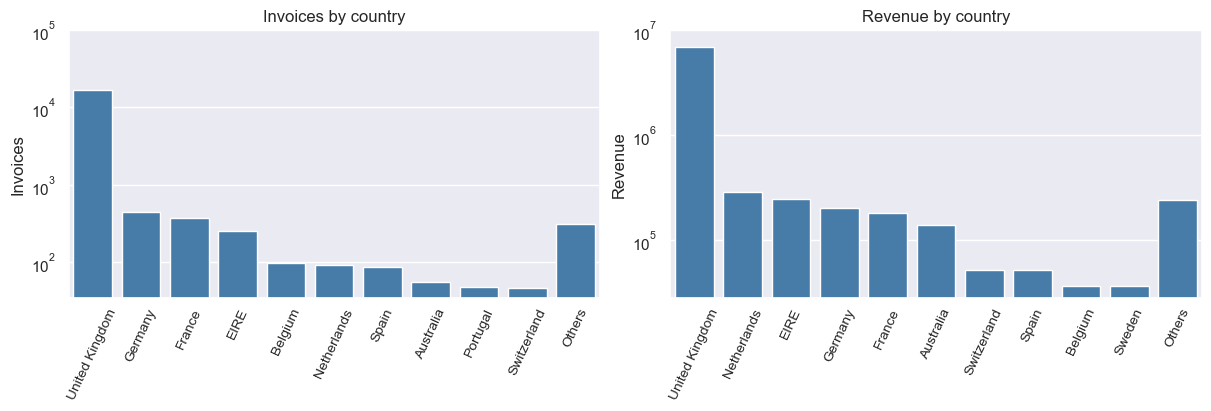

In [16]:
df_tmp_1 = (pd.DataFrame(df.groupby('Country')['InvoiceNo'].nunique())
                .sort_values(by='InvoiceNo', ascending=False)
                .rename(columns={'InvoiceNo':'Invoices'})
        )
df_tmp_1 = pd.concat(
    [df_tmp_1.iloc[0:10], pd.DataFrame({'Invoices': np.sum(df_tmp_1.iloc[10:, 0])}, index=['Others'])], 
    ignore_index=False, axis=0
)
df_tmp_2 = (pd.DataFrame(df.groupby('Country')['Revenue'].sum())
                .sort_values(by='Revenue', ascending=False)
        )
df_tmp_2 = pd.concat(
    [df_tmp_2.iloc[0:10], pd.DataFrame({'Revenue': np.sum(df_tmp_2.iloc[10:, 0])}, index=['Others'])], 
    ignore_index=False, axis=0
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), layout='constrained')
sns.barplot(x=df_tmp_1.index, y=df_tmp_1['Invoices'], color='#377EB8', ax=ax1)
sns.barplot(x=df_tmp_2.index, y=df_tmp_2['Revenue'], color='#377EB8', ax=ax2)

ax1.set(
    title='Invoices by country', 
    yscale='log', 
    ylim=(None, 10e4)
)
ax2.set(
    title='Revenue by country', 
    yscale='log',
    ylim=(None, 10e6)
)
ax1.tick_params(axis='x', labelrotation=65, labelsize='small', pad=0)
ax2.tick_params(axis='x', labelrotation=65, labelsize='small', pad=0)

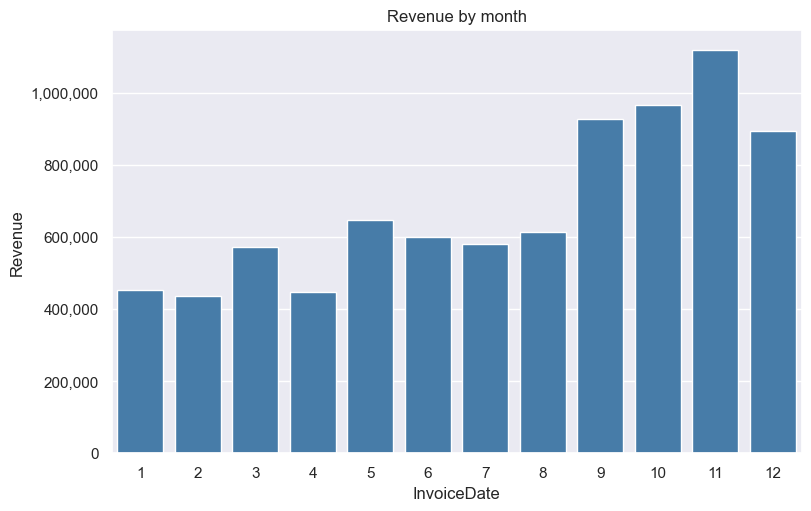

In [17]:
fig, ax = plt.subplots(figsize=(8, 5), layout='constrained')
sns.barplot(
    x=df['InvoiceDate'].dt.month, 
    y=df['Revenue'], 
    estimator='sum', 
    errorbar=None, 
    color='#377EB8', 
    ax=ax
)

ax.ticklabel_format(axis='y', style='plain')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set(title='Revenue by month');

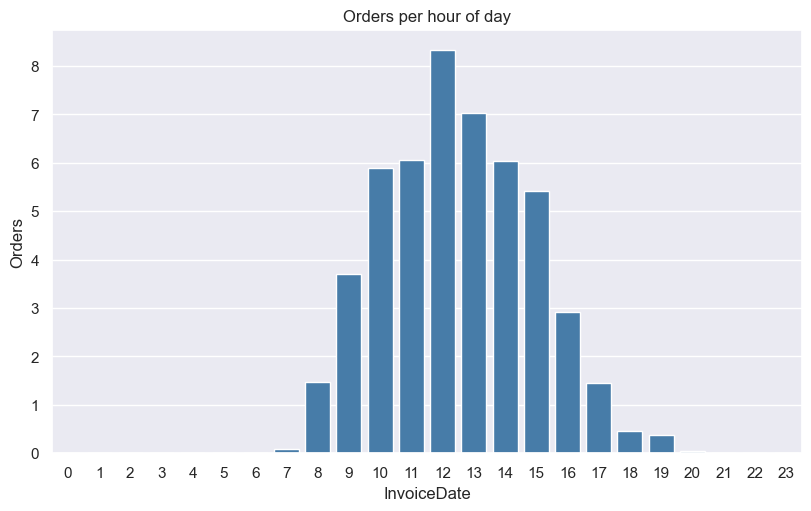

In [18]:
df_tmp = df.set_index('InvoiceDate').loc[:, ['InvoiceNo', 'CustomerID']].drop_duplicates().copy()
df_tmp = df_tmp.groupby((pd.Grouper(freq="H"))).count().reset_index()

fig, ax = plt.subplots(figsize=(8, 5), layout='constrained')
sns.barplot(
    x=df_tmp['InvoiceDate'].dt.hour,
    y=df_tmp['InvoiceNo'], 
    estimator='mean', 
    errorbar=None, 
    color='#377EB8', 
    ax=ax
)

ax.set(title='Orders per hour of day', ylabel='Orders');

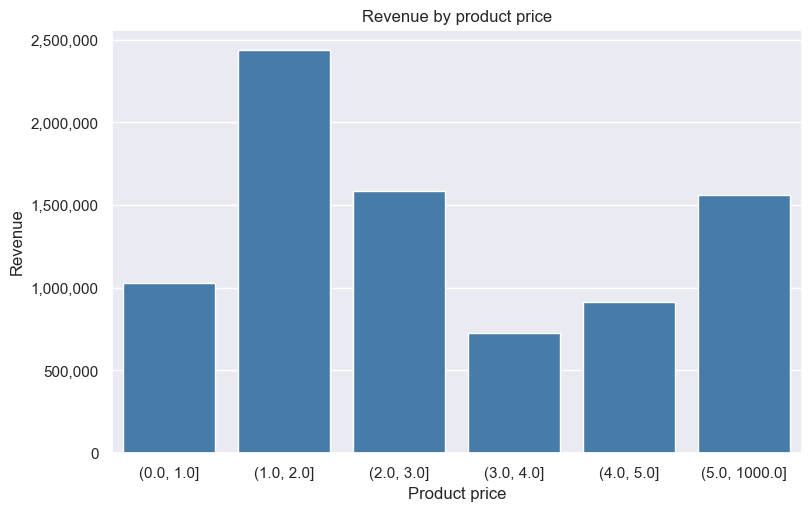

In [19]:
df['UnitPriceBin'] = pd.cut(df['UnitPrice'], 
        bins=pd.IntervalIndex.from_tuples([(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 10e2)])
)

fig, ax = plt.subplots(figsize=(8, 5), layout='constrained')
sns.barplot(
    x=df['UnitPriceBin'],
    y=df['Revenue'], 
    estimator='sum', 
    errorbar=None, 
    color='#377EB8', 
    ax=ax
)

ax.set(title='Revenue by product price', xlabel='Product price')
ax.ticklabel_format(axis='y', style='plain')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'));

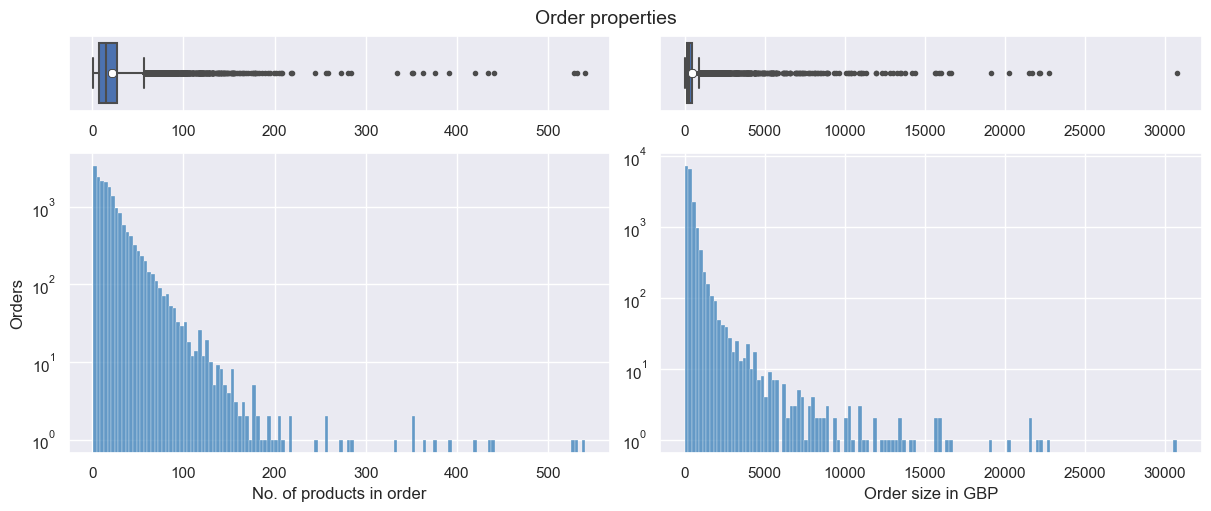

In [20]:
df_tmp = df.groupby('InvoiceNo')['Revenue'].agg(['sum', 'count'])
boxplot_dict = {'saturation': 0.1, 
                'showmeans': True,
                'width': 0.8, 
                'fliersize': 6,
                'boxprops': {'facecolor': 'C0', 'edgecolor': '#4C4D4E', 'linewidth': 1.5},
                'flierprops': {"marker": "."},
                'meanprops': {'marker': '8', 'markerfacecolor': 'w', 'markeredgecolor': '#4C4D4E', 'markeredgewidth': 0.75}
            }

fig, ax = plt.subplots(2, 2, figsize=(12, 5), gridspec_kw={"height_ratios": (0.2, 0.8)}, layout='constrained')
sns.boxplot(x=df_tmp['count'], **boxplot_dict, ax=ax[0, 0])
sns.boxplot(x=df_tmp['sum'], **boxplot_dict, ax=ax[0, 1])
sns.histplot(x=df_tmp['count'], bins='sqrt', color='#377EB8', ax=ax[1, 0])
sns.histplot(x=df_tmp['sum'], bins='sqrt', color='#377EB8', ax=ax[1, 1])

fig.suptitle(f'Order properties', fontsize=14)
ax[0, 0].set(xlabel=None)
ax[0, 1].set(xlabel=None)
ax[1, 0].set(xlabel='No. of products in order', ylabel='Orders', yscale='log')
ax[1, 1].set(xlabel='Order size in GBP', ylabel=None, yscale='log');

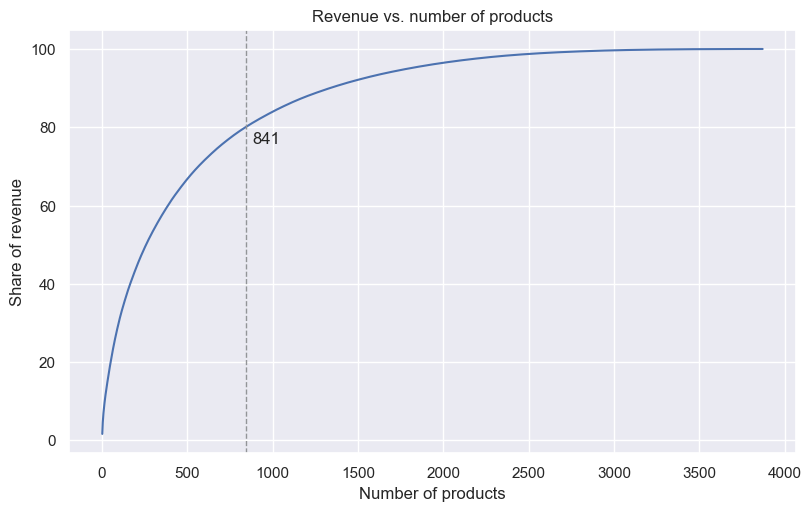

In [21]:
df_tmp = pd.DataFrame(df.groupby('Description')['Revenue'].sum()).sort_values(by='Revenue', ascending=False)
df_tmp['Share'] = df_tmp['Revenue'] / df_tmp['Revenue'].sum() * 100
df_tmp['Share of revenue'] = df_tmp['Share'].cumsum()
df_tmp['Number of products'] = np.arange(1, df_tmp.shape[0] + 1)

fig, ax = plt.subplots(figsize=(8, 5), layout='constrained')
sns.lineplot(
    x=df_tmp['Number of products'],
    y=df_tmp['Share of revenue'], 
    ax=ax
)
ax.axvline(
    x=df_tmp.iloc[np.argmax(df_tmp['Share of revenue'].to_numpy() > 80)]['Number of products'], 
    linewidth=1, 
    linestyle='--', 
    color='#939598'
)
ax.text(
    1.05 * df_tmp.iloc[np.argmax(df_tmp['Share of revenue'].to_numpy() > 80)]['Number of products'],
    0.95 * 80,
    str(int(df_tmp.iloc[np.argmax(df_tmp['Share of revenue'].to_numpy() > 80)]['Number of products'])),
    fontsize='medium'
)

ax.set(title='Revenue vs. number of products');

---

После очистки данных от выбросов и некорректных значений, предварительный анализ данных показывает, что большинство заказов - как в количественном, так и в денежном выражении приходится на местный для магазина рынок в Великобритании. Далее, с большим отрывом, в десятки основных клиентов входят покупатели из европейских стран. С учетом специфики реализуемой продукции наблюдается значительный всплеск продаж в конце года, вызванный распродажами в период празднования Хэллоуина, рождества и нового года. Исходя из графика заказов по часам, можно предположить, что большинство заказов оформляется в рабочие часы с пиком в обеденный перерыв.

Подавляющую часть выручки генерируется товарами, которые стоят всего несколько фунтов. В среднестатистическом заказе присутствует всего несколько позиций на незначительную сумму. В тоже время есть несвойственные заказы, - от крупных, оптовых клиентов - содержащие несколько сотен номенклатур на десятки тысяч фунтов. При кластеризации клиентов, необходимо учитывать наличие подобных клиентов и заказов.

Ассортимент интернет-мазана состоит из почти четырех позиций, однако только 841 из них генерируют 80% выручки.

---

### 2.3. Построение RFM-таблицы и поиск RFM-выбросов

Мы добрались до самой интересной части нашей задачи. Нам предстоит сформировать признаки, на основе которых мы будем производить сегментацию клиентов.

Для этого давайте познакомимся с очень популярным методом для анализа потребительской ценности под названием RFM. 

<center><img src="https://miro.medium.com/max/1400/1*uYQjy9SUjW7iWHc2gGanQQ.png" width="300"/></center>

Метод заключается в группировке клиентов на основе следующих параметров:
* Recency (Давность) — давность последней покупки клиента;
* Frequency (Частота) — общее количество покупок клиента;
* Monetary Value (Денежная ценность) — сколько денег потратил клиент.


Суть RFM-анализа состоит в том, что мы разделяем всех клиентов на группы в зависимости от того, как давно они сделали последнюю покупку, как часто покупали и насколько большой была сумма их заказов. 

Например, вот так может выглядеть интерпретация кластеров для случая RF-сегментации (анализа на основе давности и частоты заказов клиента):

<center><img src=https://retailrocket.ru/wp-content/uploads/2017/06/rfm-1.png width="600"></center>

Задача маркетологов — вести клиента в зону лояльных.

Мы можем рассчитать RFM-характеристики для каждого из клиентов в нашем датасете и на их основе с помощью методов кластеризации построить подобные сегменты клиентов, привязанные к нашим данным.

Чтобы получить RFM-таблицу, нам необходимо сгруппировать данные по идентификаторам клиента и рассчитать следующие  агрегированные характеристики:

* Recency для i-го клиента рассчитывается как разница между датой и временем последнего заказа и точкой отсчёта, переведённая в дни:
    $$t_0-max(t_{i1}, t_{i2},..., t_{iM})$$

    где $t_{ij}$ — дата и время совершения i-ым клиентом своей j-ой покупки.

    В качестве точки отсчёта $t_0$ берём дату на один день «старше», чем все наши данные. Это будет 10 декабря 2011 года (в формате datetime — '2011-12-10 00:00:00').

* Frequency рассчитывается как общее количество уникальных заказов, которые совершил i-ый клиент.
* Monetary Value рассчитывается как общая сумма денег, которую i-ый клиент потратил на наши товары (с учётом возвратов).

Когда вы рассчитаете все характеристики, не забудьте дать столбцам результирующей таблицы соответствующие названия.

In [22]:
rfm = (df.groupby('CustomerID').agg({
            'InvoiceDate': lambda x: ((df['InvoiceDate'].max() + pd.Timedelta(days=1)) - x.max()).days, 
            'InvoiceNo': lambda x: x.nunique(),
            'Revenue': lambda x: x.sum()
        })
        .rename(columns={
            'InvoiceDate': 'Recency',
            'InvoiceNo': 'Frequency',
            'Revenue': 'MonetaryValue'
        })
    )
rfm.sample(5)

,Recency,Frequency,MonetaryValue
CustomerID,,,
13093,276,8,"7,797.5800"
12395,19,12,"2,662.2800"
16212,19,2,681.1900
12478,4,1,545.9900
15018,39,3,456.2600


После того как вы подготовите RFM-таблицу, визуализируйте каждую из трёх компонент, например, в виде коробчатых диаграмм (boxplot).

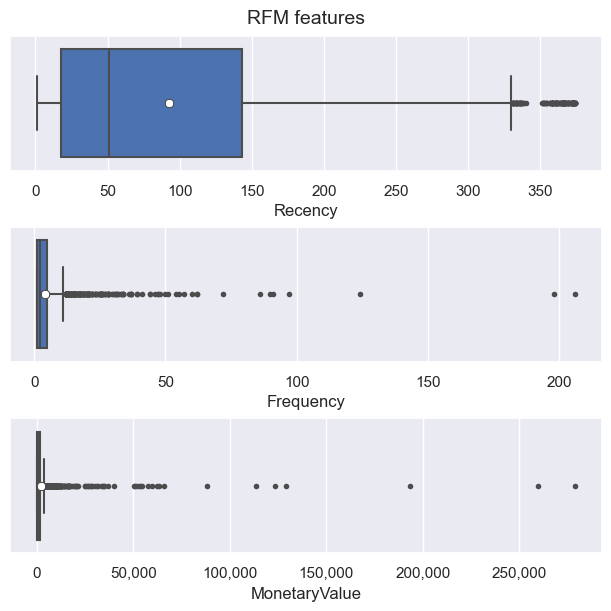

In [23]:
fig, ax = plt.subplots(3, 1, figsize=(6, 6), layout='constrained')

for i, col in enumerate(rfm.columns):
    sns.boxplot(x=rfm[col], **boxplot_dict, ax=ax[i])

fig.suptitle(f'RFM features', fontsize=14)
ax[2].xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'));

Что интересного здесь можно увидеть? Есть клиенты с аномально большим количеством сделанных заказов (более 100 штук), а также клиенты, общая стоимость заказов которых превышает 190 тысяч фунтов стерлингов.

Чем это плохо? Выбросы могут отрицательно сказаться на результатах работы методов кластеризации, неустойчивых к ним, например алгоритма KMeans, поэтому хотелось бы от них избавиться. Однако терять много ценных данных о клиентах тоже не хочется, поэтому ограничимся верхней границей соответствующей квантили уровня 0.95. Таким образом, мы удалим данные тех клиентов, для которых значение параметра Frequency или параметра Monetary выше, чем у 95 % клиентов.


In [24]:
print(f'Data shape {rfm.shape}')
for col in rfm.columns:
    rfm = rfm.drop(index=rfm[rfm[col] > rfm[col].quantile(0.95)].index)
    print(f'Data shape {rfm.shape}')

Data shape (4334, 3)
Data shape (4122, 3)
Data shape (3917, 3)
Data shape (3721, 3)


## 3. Моделирование и оценка качества моделей

### 3.1. Кластеризация на основе RFM-характеристик

Чтобы результаты кластеризации было удобнее интерпретировать, вы можете уменьшить размерность исходных признаков до двух компонент.

**Подсказка.** Чтобы методы понижения размерности работали стабильно, данные необходимо стандартизировать/нормализовать. Для удобства оберните эти шаги по предобработке данных в pipeline.

Произведите предобработку исходных данных. На основе RFM-признаков кластеризуйте клиентов онлайн-магазина подарков с помощью известных вам методов (используйте минимум три метода).

Подберите оптимальное количество кластеров для выбранных методов с помощью коэффициента силуэта, перебирая возможные значения от 3 до 10 включительно (большее или меньшее количество кластеров будет нерелеватно для маркетинга). 

Выберите алгоритм с наибольшим коэффициентом силуэта, сделайте предсказание меток кластеров.


In [25]:
rfm.corr()

,Recency,Frequency,MonetaryValue
Recency,1.0000,-0.3822,-0.3265
Frequency,-0.3822,1.0000,0.7341
MonetaryValue,-0.3265,0.7341,1.0000


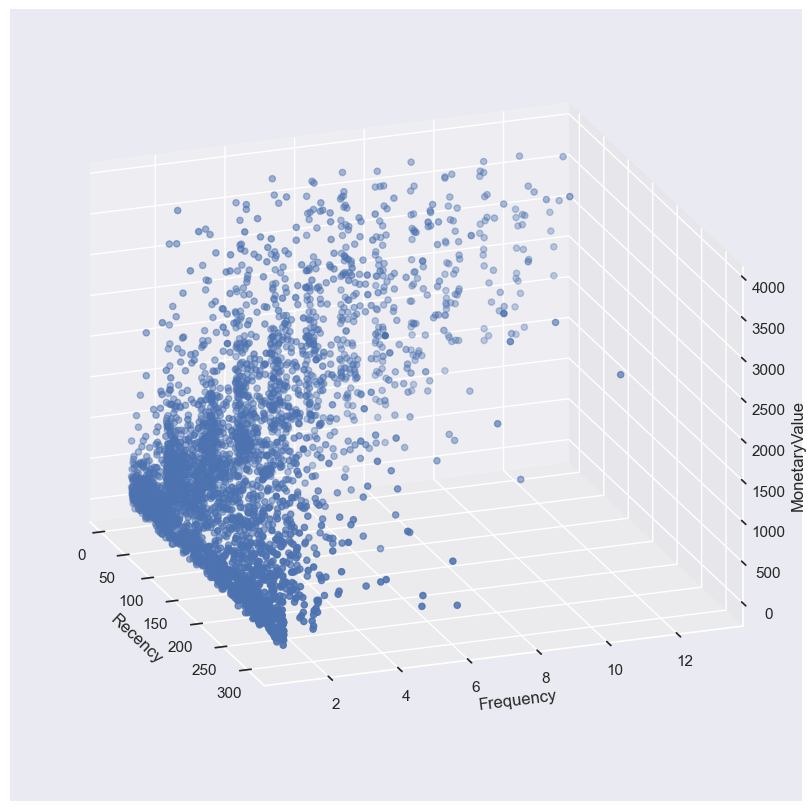

In [26]:
fig, ax = plt.subplots(figsize=(8, 8), layout='constrained', subplot_kw={'projection': '3d'})
ax.scatter(rfm['Recency'], rfm['Frequency'], rfm['MonetaryValue'])
ax.set_proj_type('ortho')
ax.view_init(elev=20, azim=-20, roll=0)
ax.set(xlabel='Recency', ylabel='Frequency', zlabel='MonetaryValue');

In [27]:
# PCA pipeline
scaler = preprocessing.StandardScaler()
pca = decomposition.PCA(n_components=2, random_state=42)
pipe_pca = pipeline.Pipeline([('Scaler', scaler), ('PCA', pca)])
pipe_pca.fit(rfm)
rfm_pca = pipe_pca.fit_transform(rfm)

In [28]:
# TSNE pipeline
t_sne = manifold.TSNE(n_components=2, n_jobs=-1, metric='euclidean', perplexity=1, random_state=42)
pipe_tsne = pipeline.Pipeline([('Scaler', scaler), ('T_SNE', t_sne)])

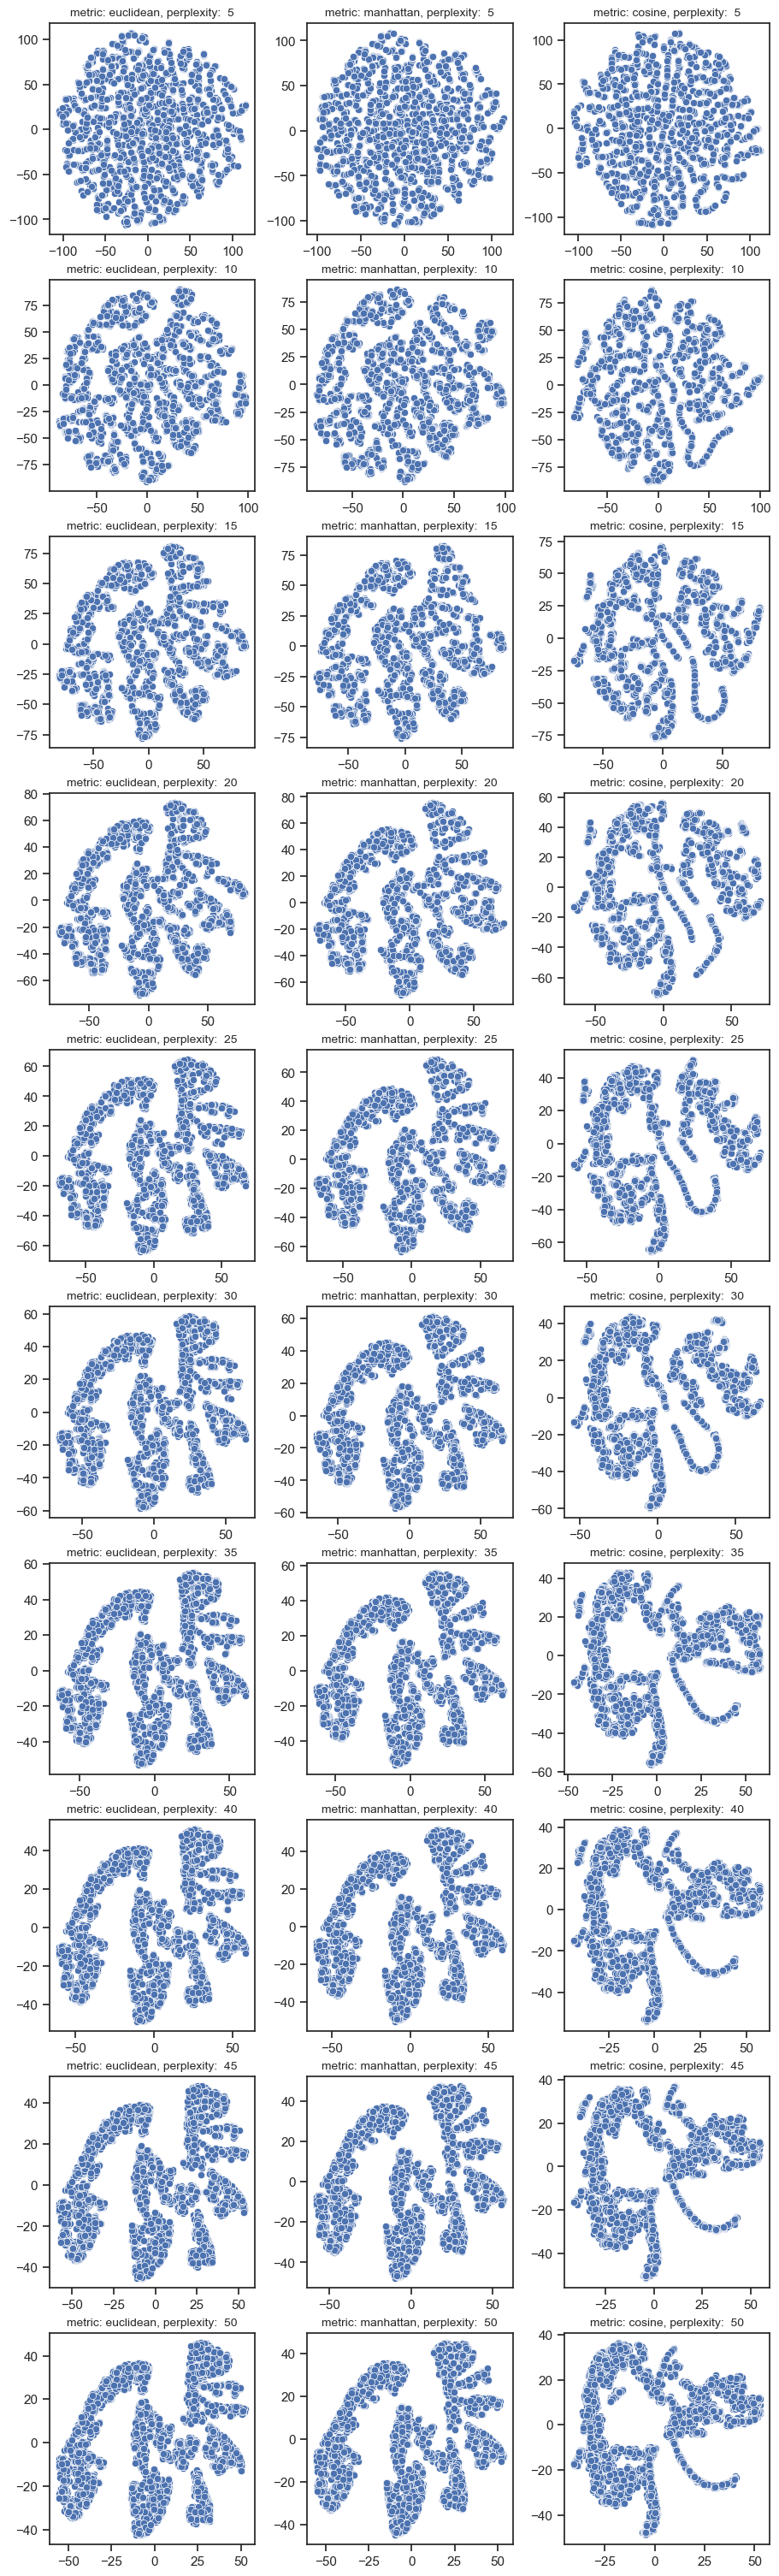

In [29]:
# TSNE study (choose: ['euclidean', 40] )
with sns.axes_style("ticks"):
    tsne_grid = [[m, p] for p in np.arange(5, 55, 5) for m in ['euclidean', 'manhattan', 'cosine']]
    fig, ax = plt.subplots(10, 3, figsize=(3*3, 10*3), layout='constrained')

    for i, x in enumerate(ax.flat):
        pipe_tsne.set_params(**{'T_SNE__metric': tsne_grid[i][0], 'T_SNE__perplexity': tsne_grid[i][1]})
        rfm_tsne = pipe_tsne.fit_transform(rfm)
        sns.scatterplot(x=rfm_tsne[:, 0], y=rfm_tsne[:, 1], ax=x)
        x.set_title(f"metric: {pipe_tsne.get_params()['T_SNE__metric']}, perplexity: {pipe_tsne.get_params()['T_SNE__perplexity']: 1}", **{'fontsize': 10})

In [30]:
pipe_tsne.set_params(**{'T_SNE__metric': 'euclidean', 'T_SNE__perplexity': 40})
rfm_tsne = pipe_tsne.fit_transform(rfm)

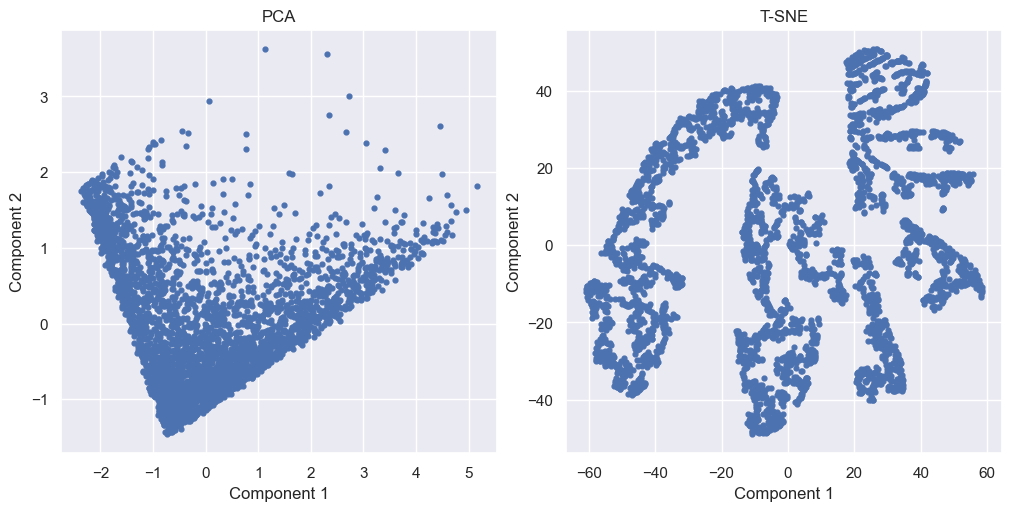

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), layout='constrained')
ax1.scatter(rfm_pca[:, 0], rfm_pca[:, 1], s=12)
ax2.scatter(rfm_tsne[:, 0], rfm_tsne[:, 1], s=12)
ax1.set(title='PCA', xlabel='Component 1', ylabel='Component 2')
ax2.set(title='T-SNE', xlabel='Component 1', ylabel='Component 2');

In [32]:
# K-Means study
kmeans_dict= {}
kmeans_dict['clusters'] = []
kmeans_dict['silhouette_pca'] = []
kmeans_dict['silhouette_tsne'] = []

for i in range(3, 11):
    kmeans_dict['clusters'].append(i)
    k_means = cluster.KMeans(n_clusters=i, n_init='auto', random_state=42)
    k_means.fit(rfm_pca)
    kmeans_dict['silhouette_pca'].append(metrics.silhouette_score(rfm_pca, k_means.labels_))
    k_means.fit(rfm_tsne)
    kmeans_dict['silhouette_tsne'].append(metrics.silhouette_score(rfm_tsne, k_means.labels_))

pd.DataFrame(kmeans_dict).style.apply(utils.highlight_max, props='color:white;background-color:#3A435E', axis=0, subset=['silhouette_pca', 'silhouette_tsne'])

,clusters,silhouette_pca,silhouette_tsne
0,3,0.516235,0.409351
1,4,0.480460,0.468299
2,5,0.445730,0.451995
3,6,0.428405,0.451248
4,7,0.397567,0.491049
5,8,0.429509,0.485908
6,9,0.405304,0.478648
7,10,0.392913,0.484694


In [33]:
# Agglomerative clustering study
aggcluster_dict= {}
aggcluster_dict['clusters'] = []
aggcluster_dict['silhouette_pca'] = []
aggcluster_dict['silhouette_tsne'] = []

for i in range(3, 11):
    aggcluster_dict['clusters'].append(i)
    aggcluster = cluster.AgglomerativeClustering(n_clusters=i)
    aggcluster.fit(rfm_pca)
    aggcluster_dict['silhouette_pca'].append(metrics.silhouette_score(rfm_pca, aggcluster.labels_))
    aggcluster.fit(rfm_tsne)
    aggcluster_dict['silhouette_tsne'].append(metrics.silhouette_score(rfm_tsne, aggcluster.labels_))

pd.DataFrame(aggcluster_dict).style.apply(utils.highlight_max, props='color:white;background-color:#3A435E', axis=0, subset=['silhouette_pca', 'silhouette_tsne'])

,clusters,silhouette_pca,silhouette_tsne
0,3,0.473133,0.397984
1,4,0.417005,0.432588
2,5,0.386458,0.461049
3,6,0.362122,0.465265
4,7,0.376224,0.474802
5,8,0.377804,0.474215
6,9,0.354800,0.462738
7,10,0.350402,0.466610


In [34]:
# DBSCAN study
dbscan_grid = [[e, s] for e in np.arange(0.5, 10, 0.5) for s in np.arange(1, 30, 1)]

dbscan_dict= {}
dbscan_dict['eps'] = []
dbscan_dict['min_samples'] = []
dbscan_dict['clusters_pca'] = []
dbscan_dict['silhouette_pca'] = []
dbscan_dict['clusters_tsne'] = []
dbscan_dict['silhouette_tsne'] = []

for p in dbscan_grid:
    dbs = cluster.DBSCAN(eps=p[0], min_samples=p[1], n_jobs=-1)
    dbscan_dict['eps'].append(p[0])
    dbscan_dict['min_samples'].append(p[1])
    
    dbs.fit(rfm_pca)
    l = len(set(dbs.labels_)) - (1 if -1 in dbs.labels_ else 0)
    dbscan_dict['clusters_pca'].append(l)
    if l > 1:
        dbscan_dict['silhouette_pca'].append(metrics.silhouette_score(rfm_pca, dbs.labels_))
    else:
        dbscan_dict['silhouette_pca'].append(0)
    
    dbs.fit(rfm_tsne)
    l = len(set(dbs.labels_)) - (1 if -1 in dbs.labels_ else 0)
    dbscan_dict['clusters_tsne'].append(l)
    if l > 1:
        dbscan_dict['silhouette_tsne'].append(metrics.silhouette_score(rfm_tsne, dbs.labels_))
    else:
        dbscan_dict['silhouette_tsne'].append(0)

In [35]:
pd.concat([
    pd.DataFrame(dbscan_dict).sort_values(by='silhouette_tsne', ascending=False).head(4),
    pd.DataFrame(dbscan_dict).sort_values(by='silhouette_pca', ascending=False).head(4)
]).style.apply(utils.highlight_max, props='color:white;background-color:#3A435E', axis=0, subset=['silhouette_pca', 'silhouette_tsne'])

,eps,min_samples,clusters_pca,silhouette_pca,clusters_tsne,silhouette_tsne
348,6.500000,1,1,0.000000,2,0.378853
363,6.500000,16,1,0.000000,2,0.378853
349,6.500000,2,1,0.000000,2,0.378853
350,6.500000,3,1,0.000000,2,0.378853
29,1.000000,1,2,0.492143,362,0.099093
0,0.500000,1,5,0.339550,2041,0.316414
371,6.500000,24,1,0.000000,2,0.378853
365,6.500000,18,1,0.000000,2,0.378853


In [36]:
# Resulting clustering pipelines
pipe_pca_kmeans = pipeline.Pipeline([('Scaler', scaler), 
            ('PCA', pca), ('K_Means', cluster.KMeans(n_clusters=3, n_init='auto', random_state=42))])
pipe_pca_aggcluster = pipeline.Pipeline([('Scaler', scaler), 
            ('PCA', pca), ('Agg_cluster', cluster.AgglomerativeClustering(n_clusters=3))])
pipe_pca_dbscan = pipeline.Pipeline([('Scaler', scaler), 
            ('PCA', pca), ('DBSCAN', cluster.DBSCAN(eps=1.0, min_samples=1, n_jobs=-1))])

# No .tranform method for T_SNE
pipe_tsne_kmeans = cluster.KMeans(n_clusters=7, n_init='auto', random_state=42)
pipe_tsne_aggcluster = cluster.AgglomerativeClustering(n_clusters=7)
pipe_tsne_dbscan = cluster.DBSCAN(eps=6.5, min_samples=1, n_jobs=-1)

In [37]:
# Cluster predictions
rfm['pca_kmeans'] = pipe_pca_kmeans.fit_predict(rfm)
rfm['pca_aggcluster'] = pipe_pca_aggcluster.fit_predict(rfm)
rfm['pca_dbscan'] = pipe_pca_dbscan.fit_predict(rfm)

rfm['tsne_kmeans'] = pipe_tsne_kmeans.fit_predict(rfm_tsne)
rfm['tsne_aggcluster'] = pipe_tsne_aggcluster.fit_predict(rfm_tsne)
rfm['tsne_dbscan'] = pipe_tsne_dbscan.fit_predict(rfm_tsne)

rfm.sample(10)

,Recency,Frequency,MonetaryValue,pca_kmeans,pca_aggcluster,pca_dbscan,tsne_kmeans,tsne_aggcluster,tsne_dbscan
CustomerID,,,,,,,,,
13973,287,1,264.7000,1,2,1,3,6,1
15407,34,4,"1,046.7400",0,1,0,4,0,0
16433,28,1,184.2600,0,1,0,1,1,1
18156,13,2,675.6400,0,1,0,5,4,1
16293,22,10,"2,236.7400",2,0,2,2,2,0
12374,25,1,622.9300,0,1,0,1,1,1
16623,246,1,129.4500,1,2,1,3,6,1
14837,90,4,"1,641.2000",2,0,2,4,0,0
15812,107,5,"1,801.1400",2,0,2,4,2,0


---

Перед проведением кластеризации была понижена размерность данных (с трех- до двухмерного пространства) с помощью методов PCA и T-SNE. Так как последний метод не является детерминированным для определения параметров его работы были рассмотрены различные варианты настроек, в результате чего были выбраны следующие показатели: метрика - Евклидово дистанция и перплексивность - 40.

К каждому из двух наборов данных были применены несколько метод кластеризации клиентов интернет-магазина, а именно: K-Means, агломеративный алгоритм и DBSCAN. Для первых двух методов было произведено разбиение наблюдений на кластеры (от 2 до 10) и рассчитан коэффициент силуэта. Для последнего метода была подготовлена сетка параметров, в соответствии с которой была произведена предварительная кластеризации. На основании полученных результатов, метода с настройками, обеспечивающими максимальный показатель коэффициенты были отобраны для дальнейшего рассмотрения.

| Метод понижения размерности/кластеризации | PCA | T-SNE |
| --- | --- | --- |
|K-Means|Кластеров: 3|Кластеров: 7|
|Agglomerative clustering|Кластеров: 3|Кластеров: 7|
|DBSCAN|Настройки: {eps=1.0, min_samples=1}|Настройки: {eps=6.5, min_samples=1}|

---

### 3.2. Интерпретация результатов кластеризации

Перейдём к интерпретации полученных кластеров.

#### 3.2.1. Визуализация кластеров

Визуализируйте результаты кластеризации в виде 2D или 3D-диаграммы. Проанализируйте полученную диаграмму и попробуйте интерпретировать качество полученных кластеров.

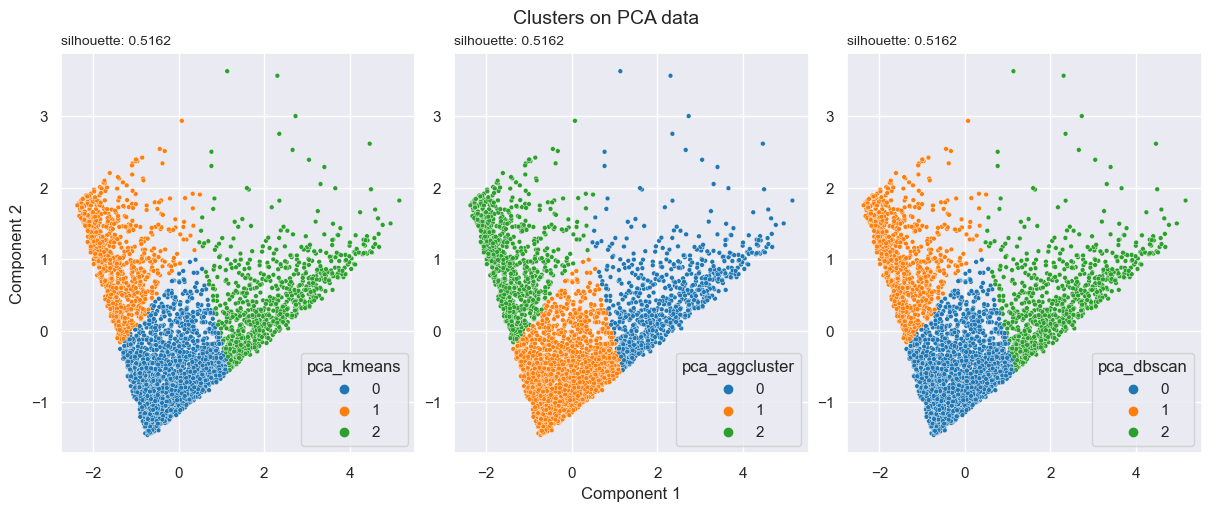

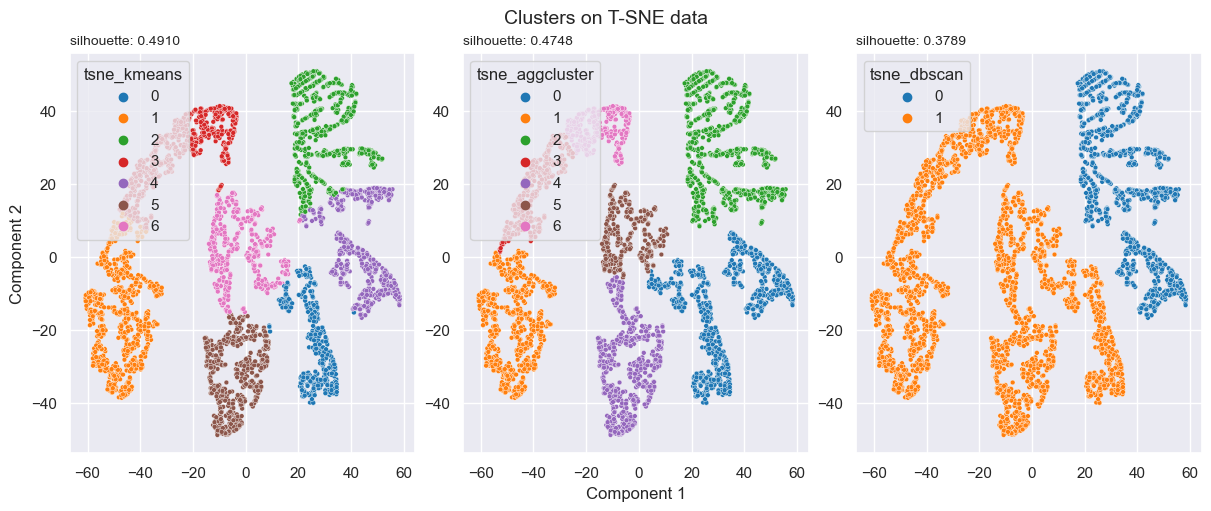

In [38]:
# Clusters in reduced sample space
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5), layout='constrained')
sns.scatterplot(x=rfm_pca[:, 0], y=rfm_pca[:, 1], hue=rfm['pca_kmeans'], s=12, ax=ax1, palette='tab10')
sns.scatterplot(x=rfm_pca[:, 0], y=rfm_pca[:, 1], hue=rfm['pca_aggcluster'], s=12, ax=ax2, palette='tab10')
sns.scatterplot(x=rfm_pca[:, 0], y=rfm_pca[:, 1], hue=rfm['pca_dbscan'], s=12, ax=ax3, palette='tab10')
fig.suptitle(f'Clusters on PCA data', fontsize=14)
ax2.set(xlabel='Component 1')
ax1.set(ylabel='Component 2')
ax1.set_title(f"silhouette: {metrics.silhouette_score(rfm_pca, rfm['pca_kmeans']):.4f}", loc='left', fontsize=10)
ax2.set_title(f"silhouette: {metrics.silhouette_score(rfm_pca, rfm['pca_aggcluster']):.4f}", loc='left', fontsize=10)
ax3.set_title(f"silhouette: {metrics.silhouette_score(rfm_pca, rfm['pca_dbscan']):.4f}", loc='left', fontsize=10)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5), layout='constrained')
sns.scatterplot(x=rfm_tsne[:, 0], y=rfm_tsne[:, 1], hue=rfm['tsne_kmeans'], s=12, ax=ax1, palette='tab10')
sns.scatterplot(x=rfm_tsne[:, 0], y=rfm_tsne[:, 1], hue=rfm['tsne_aggcluster'], s=12, ax=ax2, palette='tab10')
sns.scatterplot(x=rfm_tsne[:, 0], y=rfm_tsne[:, 1], hue=rfm['tsne_dbscan'], s=12, ax=ax3, palette='tab10')
fig.suptitle(f'Clusters on T-SNE data', fontsize=14)
ax2.set(xlabel='Component 1')
ax1.set(ylabel='Component 2')
ax1.set_title(f"silhouette: {metrics.silhouette_score(rfm_tsne, rfm['tsne_kmeans']):.4f}", loc='left', fontsize=10)
ax2.set_title(f"silhouette: {metrics.silhouette_score(rfm_tsne, rfm['tsne_aggcluster']):.4f}", loc='left', fontsize=10)
ax3.set_title(f"silhouette: {metrics.silhouette_score(rfm_tsne, rfm['tsne_dbscan']):.4f}", loc='left', fontsize=10);

---

Выше представлены результаты кластеризации для всех отобранных комбинаций методов понижения размерности/кластеризации в двухмерном пространстве. Для данных, полученных с помощью PCA, все методы показывают схожие результаты: визуально и по показателю коэффициента силуэта. Для данных, полученных с помощью T-SNE, для методов K-Means и агломеративный алгоритм оптимальным является разбиение выборки клиентов на семь кластеров; для метода DBSCAN - по-прежнему три кластера с наименьшим коэффициентом силуэта.

Исходя из бизнес требований о классификации клиентов в разрезе трех метрик предлагаемые схемы кластеризации на три группы выглядят не достаточно детализированными чтобы сегментировать клиентскую базу. Для проверки валидности данного утверждения в дополнение методу кластеризации с наибольшим показателем метрики (T-SNE/K-Means) также был выбран вариант PCA/K-Means.

---

#### 3.2.2. Построение профиля кластеров

Далее составьте так называемый профиль кластеров. Для этого вам необходимо вернуться от декомпозированных данных (если вы производили понижение размерности) к RFM-таблице (очищенной от выбросов).

Сгруппируйте RFM-таблицу по полученным кластерам и рассчитайте среднее по каждому из признаков.

Чтобы результаты было проще интерпретировать, давайте познакомимся с одним из способов визуализации профиля кластеров — **Radar Chart** (полярная диаграмма, или диаграмма паутины). Это графическое представление значений нескольких эквивалентных категорий в форме паутины.

Radar Chart часто используется при определении профиля кластеров. На концах паутины откладываются оси, соответствующие признакам, описывающим объекты. На каждой из осей для каждого кластера откладываются средние значения соответствующих характеристик. Соединив точки по осям, мы получаем многоугольник. 

Пример полярной диаграммы для задачи кластеризации учеников по интересам:

<img src=https://www.datanovia.com/en/wp-content/uploads/2020/12/radar-chart-in-r-customized-fmstb-radar-chart-1.png width=350>

На этой диаграмме мы видим визуализацию признаков для одного из кластеров. Видно, что ученики, принадлежащие этому кластеру, в большей степени увлекаются музыкой (Music), а в меньшей — программированием (Programm).

В модуле `graph_objects` библиотеки `plotly` есть встроенная функция `Scatterpolar`, которая позволяет построить полярную диаграмму. На основе этой функции мы подготовили для вас функцию `plot_cluster_profile()`, которая позволяет визуализировать профиль каждого из кластеров в виде полярной диаграммы. У неё есть два параметра: `grouped_data` — сгруппированные по кластерам характеристики объектов (клиентов), `n_clusters` — количество кластеров.

Главное условие использования полярной диаграммы — все признаки должны быть приведены к единому масштабу с помощью нормализации, где 1 будет означать максимум, а 0 — минимум. Шаг с нормализацией мы также добавили в функцию `plot_cluster_profile()`.

```py
def plot_cluster_profile(grouped_data, n_clusters):
    """Функция для визуализации профиля кластеров в виде полярной диаграммы.

    Args:
        grouped_data (DataFrame): таблица, сгруппированная по номерам кластеров с агрегированными характеристиками объектов.
        n_clusters (int): количество кластеров
    """
    # Нормализуем сгруппированные данные, приводя их к масштабу 0-1.
    scaler = preprocessing.MinMaxScaler()
    grouped_data = pd.DataFrame(scaler.fit_transform(grouped_data), columns=grouped_data.columns)
    # Создаём список признаков
    features = grouped_data.columns
    # Создаём пустую фигуру
    fig = go.Figure()
    # В цикле визуализируем полярную диаграмму для каждого кластера
    for i in range(n_clusters):
        # Создаём полярную диаграмму и добавляем её на общий график
        fig.add_trace(go.Scatterpolar(
            r=grouped_data.iloc[i].values, # радиусы
            theta=features, # название засечек
            fill='toself', # заливка многоугольника цветом
            name=f'Cluster {i}', # название — номер кластера
        ))
    # Обновляем параметры фигуры
    fig.update_layout(
        showlegend=True, # отображение легенды
        autosize=False, # устаналиваем свои размеры графика
        width=800, # ширина (в пикселях)
        height=800, # высота (в пикселях)
    )
    # Отображаем фигуру
    fig.show()
```

Теперь у вас есть удобный инструмент для анализа профиля кластеров. Воспользуйтесь им, чтобы проинтерпретировать результаты, полученные на предыдущем шаге.

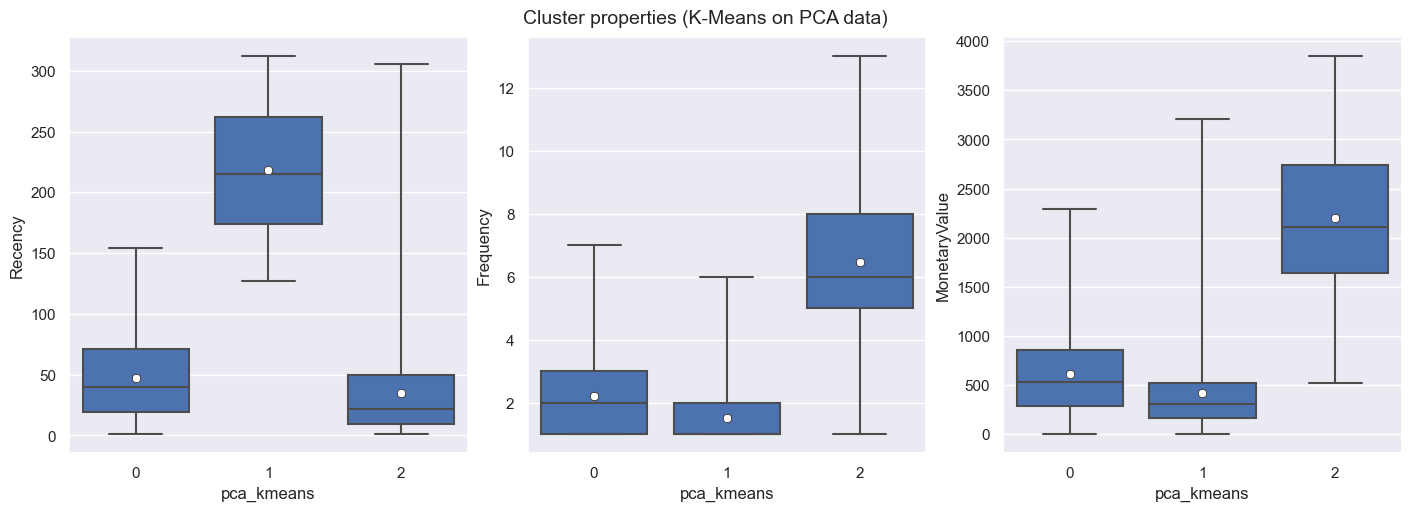

In [39]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 5), layout='constrained')
sns.boxplot(x=rfm['pca_kmeans'], y=rfm['Recency'], whis=(0, 100), **boxplot_dict, ax=ax1)
sns.boxplot(x=rfm['pca_kmeans'], y=rfm['Frequency'], whis=(0, 100), **boxplot_dict, ax=ax2)
sns.boxplot(x=rfm['pca_kmeans'], y=rfm['MonetaryValue'], whis=(0, 100), **boxplot_dict, ax=ax3)
fig.suptitle(f'Cluster properties (K-Means on PCA data)', fontsize=14);

---

Три кластера клиентов, которые были получены с помощью PCA/K-Means, рассматриваемые с точки зрения RFM модели, характеризуются следующим образом:
* Кластер 0 - постоянные клиенты, покупающие среднее количество товара относительно часто и постоянно;
* Кластер 1 - клиенты, приносящие минимальную выручку магазину: имеют наименьший средний чек при редко встречающихся покупках, последняя из которых была как минимум 4 месяца назад;
* Кластер 2 - наиболее лояльные клиенты. Те, кто покупают чаще всего и имеют наивысший средний чек.

При такой сегментации клиентов получается довольно грубая картина клиентов. Заинтересованные стороны, как минимум заходят видеть более детализированную картину по постоянным клиентам, а также клиентам, которые находятся в зоне риска, а не постфактум потерянных.

---

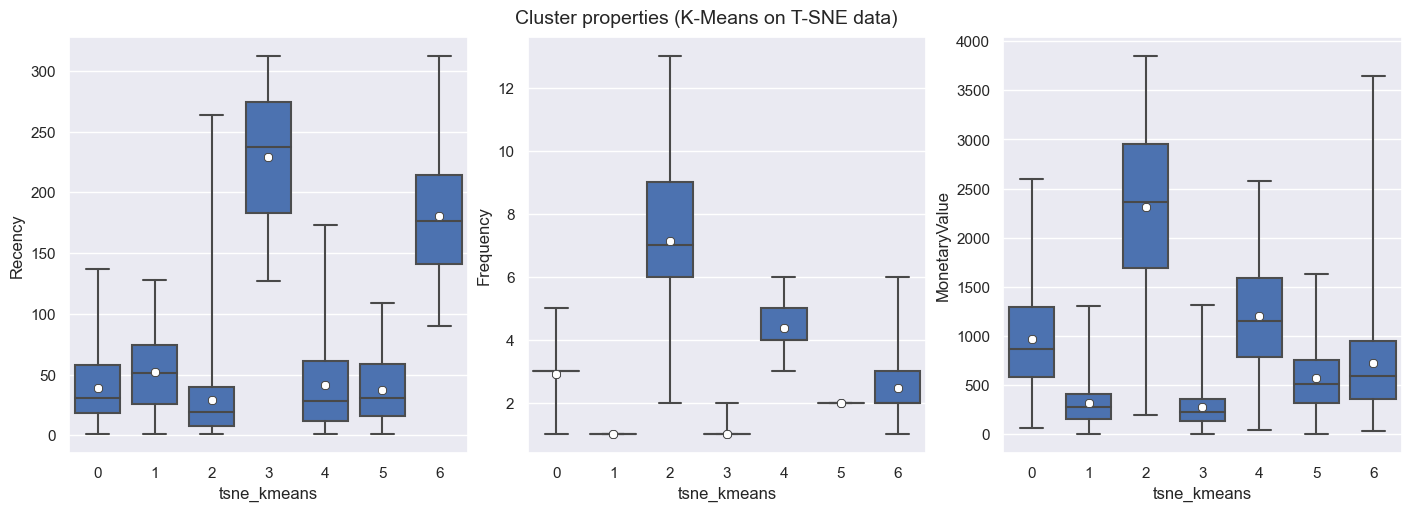

In [40]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 5), layout='constrained')
sns.boxplot(x=rfm['tsne_kmeans'], y=rfm['Recency'], whis=(0, 100), **boxplot_dict, ax=ax1)
sns.boxplot(x=rfm['tsne_kmeans'], y=rfm['Frequency'], whis=(0, 100), **boxplot_dict, ax=ax2)
sns.boxplot(x=rfm['tsne_kmeans'], y=rfm['MonetaryValue'], whis=(0, 100), **boxplot_dict, ax=ax3)
fig.suptitle(f'Cluster properties (K-Means on T-SNE data)', fontsize=14);

---

C помощью T-SNE/K-Means клиентская база разделяется на семь групп клиентов:
* Кластер 2 - очевидно представляет оптовых клиентов, у которых самый высокий средний чек и высокий разброс в частоте и давности покупок;
* Кластер 0 и 4 - постоянные/лояльные клиенты со стабильным средним чеком и постоянными заказами. Средняя выручка от последней группы немного выше за счет более часто оформляемых заказов;
* Кластер 1 и 5 - постоянные, но редко обращающиеся клиенты со средним чеком, который меньше чем у лояльных клиентов. Средняя выручка от последней группы, опять же, немного выше за счет более часто оформляемых заказов
* Кластер 6 - ранее активные розничные клиенты, которые длительное время не обращались с новыми клиентами (в зоне риска);
* Кластер 3 - более не активные клиенты (в т.ч. оптовые клиенты), которые не обращались с новыми заказами очень продолжительное время (в зоне потери).

Полученные группы более соответствует RFM додели сегментирования клиентской базы и может служить как база для формирования итоговых групп покупателей совместно с нормативами, принятыми внутри компании.

---

## 5. Выводы и оформление работы

Напишите заключение о проделанной работе и полученных результатах. Отметьте, какие сегменты клиентов вам удалось найти в данных.

После завершения проекта создайте в своём репозитории файл README.md и кратко опишите содержимое проекта по принципу, который мы приводили ранее.

Выложите свой проект на GitHub и оформите удалённый репозиторий, добавив в него описание и теги репозитория (теги придумайте самостоятельно в зависимости от того, какую задачу вы решали).

---

В проектной работе продемонстрирована работа с базовыми методами понижения размерности данных и кластеризации алгоритмы обучения без учителя (кластеризации). На основе учебных данных сегментирована клиентская база интернет-магазина, после проведения существенной очистки данных от некорректных наблюдений, которая может быть использована при формировании RFM анализа клиентов.

---
